<center>
            <h1>
   OCR for Chinese City Parking Dataset
            </h1>
    </center>
<center>
            by Alexander Potekhin
</center>
<center>
    Date: 25/12/2022
</center>

## **1. Setup**

### **1.1. Load data**

In [1]:
import torch
import torch.nn as nn
import PIL
import numpy as np

from matplotlib import pyplot as plt
from torchmetrics.functional import char_error_rate
from tqdm.notebook import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from IPython.display import clear_output


In [2]:
TRAIN_DIR = Path("./CCPD2019-dl1/train")
TEST_DIR = Path("./CCPD2019-dl1/test")

DEVICE = torch.device("cuda")

In [3]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print("Train files -- ", len(train_val_files))
print("Test files -- ", len(test_files))

Train files --  199980
Test files --  9999


In [4]:
# checking all samples have the same length

for file in test_files:
    assert len(file.stem[-7:]) == 7

In [5]:
# getting all possible characters from train_files

characters = []
for train_file in train_val_files:
    for train_file_letter in list(train_file.stem[-7:]):
        if train_file_letter not in characters:
            characters.append(train_file_letter)

In [6]:
characters = sorted(characters)
''.join(characters)

'0123456789ABCDEFGHJKLMNOPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑'

In [7]:
len(characters)

66

### **1.2. Visualizing tools**

In [8]:
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [9]:
def imshow(inp, title=None, plt_ax=plt, preds=None, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title:
        plt_ax.set_title("Ground truth: " + title, fontsize=14)
    if preds:
        plt_ax.set_xlabel("Predicted: " + preds, fontsize=14)
    plt_ax.grid(False)


In [10]:
plt.rcParams['font.family'] = ['SimHei', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False


def draw_samples(test_dataset, preds=None, error_idxs=None):
    """Draw samples from dataset with 3 options:
        1. Samples with ground truth title
        2. Samples with ground truth and predicted title
        3. Samples with ground truth and mispredicted title
        """
        
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 8),
                           sharey=True, sharex=True)
    if error_idxs:
        for fig_x, error_idx in zip(ax.flatten(), error_idxs):
            pred = preds[error_idx]
            im_val, label = test_dataset[error_idx]
            img_label = label
            imshow(im_val.data.cpu(),
                   title=img_label, plt_ax=fig_x, preds=pred)

    elif preds:
        for fig_x in ax.flatten():
            random_characters = int(np.random.uniform(0, 1000))
            pred = preds[random_characters]
            im_val, label = test_dataset[random_characters]
            img_label = label
            imshow(im_val.data.cpu(),
                   title=img_label, plt_ax=fig_x, preds=pred)

    else:
        for fig_x in ax.flatten():
            random_characters = int(np.random.uniform(0, 1000))
            im_val, label = test_dataset[random_characters]
            img_label = label
            imshow(im_val.data.cpu(),
                   title=img_label, plt_ax=fig_x)


### **1.3. Label Encoder**

In [11]:
class LabelEncoder():
    """Label encoder and decoder for CTC loss
    Insert `blank` token in the characters for CTC-loss
    """
    
    def __init__(self, characters):
        self.characters = characters + '-'  # for `-1` index
        self.char2idx = {}

        for i, char in enumerate(characters):
            self.char2idx[char] = i + 1     #  0 ind is reserved for 'blank' in CTC-loss

        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode_sample(self, text):
        """Converts string label to indexes"""
        text = [self.char2idx[char] for char in text]
        length = [len(text)]
        return (torch.IntTensor(text), torch.IntTensor(length))

    def encode(self, batch):
        """Converts labels in batch to indexes"""
        length = [len(sample) for sample in batch]
        text = ''.join(batch)
        text = [self.char2idx[char] for char in text]
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode_sample(self, text, length):
        """Converts indexes to string labels"""
        chars = []
        for i in range(length):
            if text[i] != 0 and (not (i > 0 and text[i - 1] == text[i])):
                chars.append(self.characters[text[i] - 1])
        return ''.join(chars)

    def decode(self, batch, length):
        """Converts indexes in batch to labels"""
        ind = 0
        texts = []
        for i in range(length.numel()):
            sample_len = length[i]
            texts.append(self.decode_sample(
                batch[ind: ind + sample_len], sample_len))
            ind += sample_len
        return texts


## **2. Dataset**

In [12]:
class CCPD(Dataset):
    def __init__(self, files):
        super().__init__()
        self.files = sorted(files)

    def __len__(self):
        return len(self.files)

    def load_sample(self, file):
        label = file.stem[-7:]     # get label: 1126-皖A5U628.jpg --> 皖A5U628
        img = Image.open(file)
        img.load()
        return img, label

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Resize(size=(32, 96))
        ])
        x, y = self.load_sample(self.files[index])
        x = transform(x)
        return x, y


In [13]:
#splitting train files to train and val datasets

train_size = int(len(train_val_files) * 0.8)
val_size = len(train_val_files) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    CCPD(train_val_files), [train_size, val_size])
test_dataset = CCPD(test_files)

In [14]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

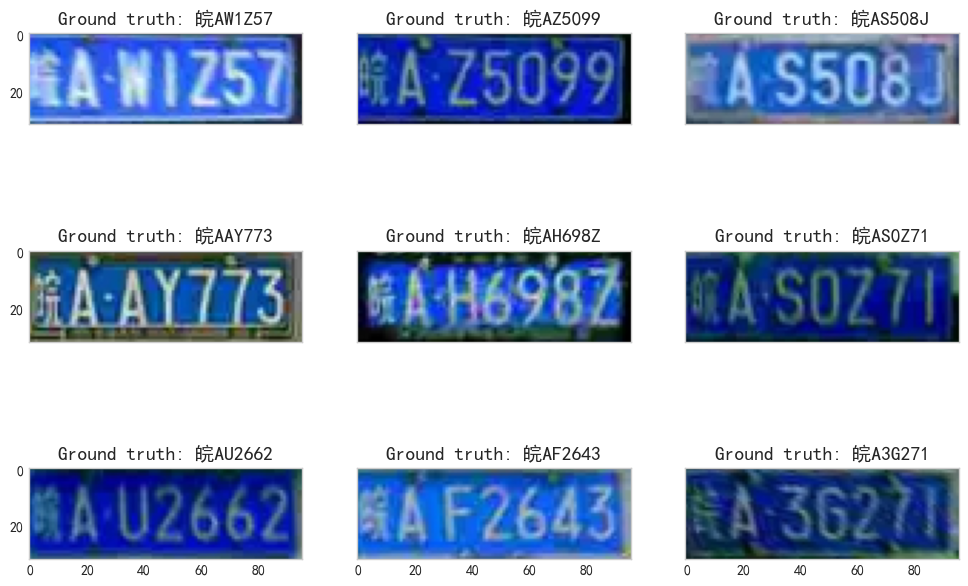

In [15]:
draw_samples(test_dataset)

## **3. Define Model**

### **3.1. Build model**

**I tried to recreate model from given img**

![alt text](arch.png)

In [16]:
class CRNN(nn.Module):
    def __init__(self, num_characters):
        super().__init__()
        self.num_characters = num_characters

        # [batch_size, 3, 32, 96]
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # [batch_size, 8, 17, 49]
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16,
                      kernel_size=3, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # [batch_size, 16, 9, 25]
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # [batch_size, 32, 4, 12]
        self.rnn = nn.Sequential(
            nn.LSTM(32 * 4, 512, batch_first=True, num_layers=2,
                    dropout=0.2, bidirectional=True),

        )
        # [batch_size, 12, 1024]
        self.clf = nn.Linear(1024, num_characters)
        
        # [12, batch_size, 67]

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        b, c, h, w = x.size()
        x, _ = self.rnn(x.view(b, w, c * h))
        x = self.clf(x)
        return x.permute(1, 0, 2)


### **3.2. Training and testing tools**

In [17]:
def accuracy(preds, y):
    accuracy = np.mean(np.array(preds) == np.array(y))
    return accuracy


In [18]:
def decode_preds(logits, label_encoder):
    """Decode logits into labels"""
    
    logits = logits.softmax(2).argmax(2).cpu()  # --> [12, 64]
    logits = logits.permute(1, 0).numpy()  # --> [64, 12]

    masked_tokens = []
    for label_decoded in logits:
        chars = []
        for char_idx in label_decoded:
            chars.append(
                label_encoder.idx2char[char_idx] if char_idx != 0 else '-')
        masked_tokens.append(chars)

    preds = []
    for label_encoded in masked_tokens:
        pred = []
        for idx, char in enumerate(label_encoded):
            if char != label_encoded[idx-1] and char != '-':
                pred.append(char)
        preds.append(''.join(pred))
    return preds


In [19]:
def get_loss(logits, text, label_encoder, criterion):
    """Calculate CTC-loss"""
    input_len, batch_size, vocab_size = logits.size()
    logits = logits.log_softmax(2)
    enc_text, text_lens = label_encoder.encode(text)
    logits_lens = torch.full(
        size=(batch_size,), fill_value=input_len, dtype=torch.int32).to(DEVICE)
    loss = criterion(logits, enc_text, logits_lens, text_lens)
    return loss


In [20]:
def train_loop(model, data_loader, label_encoder, criterion, optimizer, clip_norm):
    model.train()
    losses = []
    for img, text in tqdm(data_loader):
        optimizer.zero_grad()
        logits = model(img.to(DEVICE))
        loss = get_loss(logits, text, label_encoder, criterion)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        preds = decode_preds(logits, label_encoder)
        acc = accuracy(preds, text)

        losses.append(loss.item())

    return losses, acc


In [21]:
def val_loop(model, data_loader, label_encoder, criterion):
    model.eval()
    losses = []
    with torch.inference_mode():
        for img, text in tqdm(data_loader):
            logits = model(img.to(DEVICE))
            loss = get_loss(logits, text, label_encoder, criterion)

            preds = decode_preds(logits, label_encoder)
            acc = accuracy(preds, text)

            losses.append(loss.item())

    return losses, acc


In [22]:
def evaluate(test_dataloader, label_encoder):
    model.eval()
    losses = []
    predictions = []
    texts = []

    with torch.inference_mode():
        for img, text in tqdm(test_dataloader):
            logits = model(img.to(DEVICE))
            preds = decode_preds(logits, label_encoder)

            predictions.extend(preds)
            texts.extend(text)

    acc = accuracy(predictions, texts)
    cer = char_error_rate(predictions, texts)

    print(f'Test accuracy -- {acc}')
    print(f'Test CER -- {cer}')

    return predictions, texts


In [23]:
def train(model, optimizer, criterion, scheduler, epochs, train_dataloader, val_dataloader, label_encoder, clip_norm):
    train_losses = []
    val_losses = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        train_loss, train_acc = train_loop(model, train_dataloader, label_encoder,
                                           criterion, optimizer, clip_norm)
        val_loss, val_acc = val_loop(
            model, val_dataloader, label_encoder, criterion)
        scheduler.step()

        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        clear_output(True)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].plot(train_losses, label='train loss')
        ax[0].plot(val_losses, label='val loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Losses')
        ax[1].plot(train_acc_history, label='train accuracy')
        ax[1].plot(val_acc_history, label='validation accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Accuracy')
        plt.legend()
        plt.show()

        print(f'Epoch {epoch + 1}')
        print(
            f'Losses: train -- {np.mean(train_loss)}, val -- {np.mean(val_loss)}')
        print(f'Accuracy: train -- {train_acc}, val -- {val_acc}')


## **4. Train model**

In [24]:
model = CRNN(len(characters) + 1).to(DEVICE)    # length of chars + 1 for CTC token 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
epochs = 8
label_encoder = LabelEncoder(''.join(characters))
clip_norm = 5


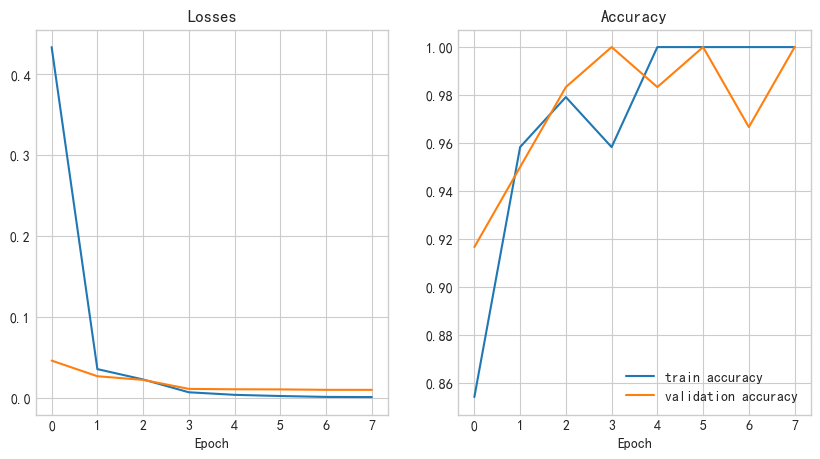

Epoch 8
Losses: train -- 0.0010650644053341238, val -- 0.010003448391897837
Accuracy: train -- 1.0, val -- 1.0


In [25]:
train(model, optimizer, criterion, scheduler, epochs,
      train_dataloader, val_dataloader, label_encoder, clip_norm)


## **5. Test model**

### **5.1. Metrics**

**Now we good to test our model**

In [26]:
preds, texts = evaluate(test_dataloader, label_encoder)

  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy -- 0.943994399439944
Test CER -- 0.01018673274666071


*We have nice and solid scores on both metrics*

**Best Test accuracy -- 0.95**
**Best Test CER -- 0.009**

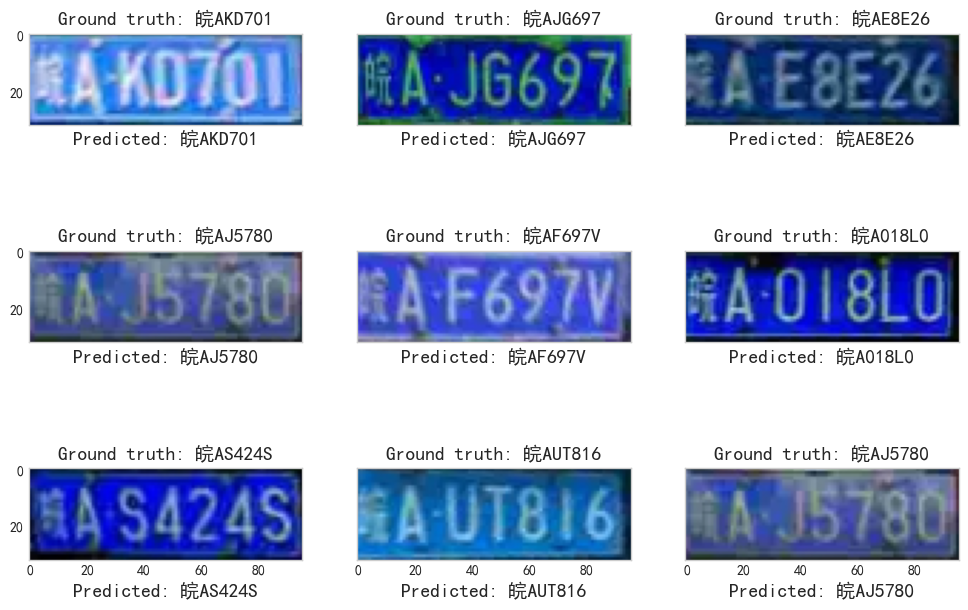

In [27]:
draw_samples(test_dataset, preds)

### **5.2. Get errors**

**Let's see where our model has the worst CER score**

In [28]:
error_inxs = []

for ind, (pred, text) in enumerate(zip(preds, texts)):
    CER = char_error_rate(pred, text).numpy()
    if CER > 0.5:   # empirically selected threshold
        error_inxs.append(ind)


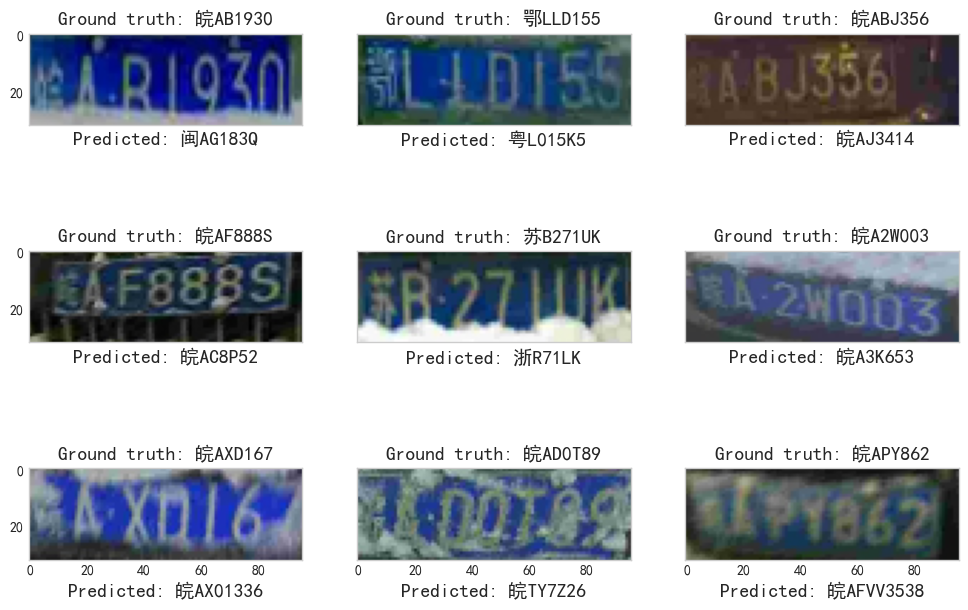

In [29]:
draw_samples(test_dataset, preds, error_inxs)


### **6. Conclusion**

**It is clearly seen that model mispredicts in case of really fuzzy samples even I could not always recognize. There is snow on the characters that covers the half of hieroglyphs**

**To conculde, I have built an OCR model on CCPD dataset with CRNN architecture. Various optimizers, shedulers and hyperparameters were tested to achieve an excellent accuracy and CER scores, but not ideal though. To improve model understanding of low-poly or distorted images i think we need to work on DATA. So I believe it's feature-extraction problem and maybe we can add augmentation (my approach with augmentation gave lower scores than without) and detect problematic pictures for upsampling before passing them into model. Also I think we can generate more images with defects by adding noise to original and train model on them**